In [1]:
from utils import load_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import ipywidgets as ipw
import tensorflow as tf

In [6]:
train_df = load_df("data\\df_concat_train.pkl")
data = train_df["champs-elysees_Débit horaire"].to_numpy()

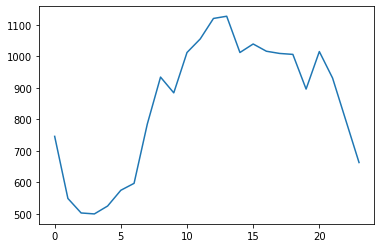

In [16]:
def get_X_y(data, nb_steps=24):
    """ returns the X and y vectors from dataframe 
        steps : nb of datapoints in each Xi
    """ 
    nb_train_ex = data.shape[0] - (nb_steps + 1) + 1 # 1 in () : the y 
    
    X = np.empty((nb_train_ex, nb_steps))
    y = np.empty((nb_train_ex,))
    for k_start in range(nb_train_ex):  
        X_k = data[k_start:k_start + nb_steps]
        y_k = data[k_start + nb_steps]

        example_id = k_start

        X[example_id, :] = X_k
        y[example_id] = y_k
#     X_tensor = tf.convert_to_tensor(X)
#     y_tensor = tf.convert_to_tensor(y)
    return X.reshape((nb_train_ex, nb_steps, 1)), y


X, y = get_X_y(data)
plt.plot(X[0])


In [17]:
def model_1(nb_steps=24, show_summary=False):
    input_shape = (nb_steps, 1)
    print("input shape : ", input_shape)
    
    model = models.Sequential()

    model.add(layers.Conv1D(256, kernel_size=(3,),
                        input_shape=input_shape, activation="relu"))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Dropout(0.2))

#     model.add(layers.Conv1D(128, kernel_size=(3,), activation="relu"))
#     model.add(layers.MaxPooling1D(3))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))
    
    if show_summary:
        model.summary()
        
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

# test
cnn_model_1 = model_1(show_summary=True) 

input shape :  (24, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 22, 256)           1024      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               229504    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (N

In [18]:
cnn_model_1.fit(X, y, batch_size=32, epochs=100, verbose=1)

Train on 9235 samples
Epoch 1/100
9235/9235 [==============================] - 5s 521us/sample - loss: 46292.8558 - mae: 154.1587
Epoch 2/100
9235/9235 [==============================] - 1s 101us/sample - loss: 29236.3886 - mae: 122.8869
Epoch 3/100
9235/9235 [==============================] - 1s 84us/sample - loss: 27686.1247 - mae: 119.7717
Epoch 4/100
9235/9235 [==============================] - 1s 83us/sample - loss: 24508.3680 - mae: 111.8144
Epoch 5/100
9235/9235 [==============================] - 1s 82us/sample - loss: 23507.9449 - mae: 109.5515
Epoch 6/100
9235/9235 [==============================] - 1s 81us/sample - loss: 22950.9917 - mae: 108.6189
Epoch 7/100
9235/9235 [==============================] - 1s 79us/sample - loss: 22280.0126 - mae: 106.8988
Epoch 8/100
9235/9235 [==============================] - 1s 80us/sample - loss: 21105.6006 - mae: 104.2597
Epoch 9/100
9235/9235 [==============================] - 1s 85us/sample - loss: 21171.7296 - mae: 103.6169
Epoch 10/100


9235/9235 [==============================] - 1s 80us/sample - loss: 10494.6980 - mae: 72.3093
Epoch 78/100
9235/9235 [==============================] - 1s 91us/sample - loss: 10914.8114 - mae: 74.3686
Epoch 79/100
9235/9235 [==============================] - 1s 83us/sample - loss: 10465.5808 - mae: 72.3613
Epoch 80/100
9235/9235 [==============================] - 1s 86us/sample - loss: 10600.2339 - mae: 73.3970
Epoch 81/100
9235/9235 [==============================] - 1s 87us/sample - loss: 10941.1640 - mae: 74.2200
Epoch 82/100
9235/9235 [==============================] - 1s 83us/sample - loss: 11089.0176 - mae: 74.4349
Epoch 83/100
9235/9235 [==============================] - 1s 87us/sample - loss: 10086.0530 - mae: 71.0449
Epoch 84/100
9235/9235 [==============================] - 1s 85us/sample - loss: 10501.7932 - mae: 72.6914
Epoch 85/100
9235/9235 [==============================] - 1s 84us/sample - loss: 11014.1219 - mae: 73.8307
Epoch 86/100
9235/9235 [==========================

752.5986


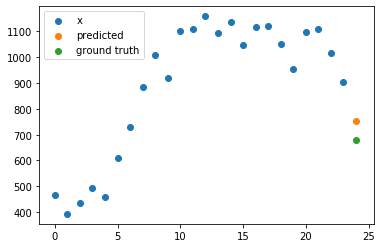

In [21]:
def show_one_pred(model, X, y, i):
    """ computes rmse & shows the predicted point """
    y_pred = model.predict(X[i].reshape(1, 24, 1))
    print(y_pred[0][0])
    abscissa = list(range(24))
    plt.scatter(abscissa, y[i:i+24], label="x")
    plt.scatter([i+24], [y_pred[0][0]], label="predicted")
    plt.scatter([i+24], y[i+24], label="ground truth")
    plt.legend()
    
show_one_pred(cnn_model_1, X, y, 0)

In [27]:
def predict_one_week(model, X):
    """ predicts y for 24*7 = 168 hours 
        first, we will only return the predicted y for <champs-elysees_Débit horaire>
        
        steps : 
            - get the 24 first values of each feature, put it in a np array
            - predict the 25th for features_to_predict
            - store <champs-elysees_Débit horaire> in a list
            - create one complete line with predicted and not predicted
            - add this line to the examples
            - take the 24 last values 
    """
    nb_predict = 24 * 7 # change to parameters
    
    # array qui contiendra les prédictions des y
    predicted_y = np.empty(nb_predict)
    # array qui contiendra les X
    X_24 = np.empty((24 + nb_predict))
    # on le remplit avec les premieres valeurs
    first_24_X = X[0].flatten()
    X_24[0:24] = first_24_X
    
    for i in range(nb_predict):
        
        # get the inputs
        next_24_X = X_24[i:24 + i].reshape(1, 24,1)
        # predict the 24+i th value
        f_y_pred = model.predict(next_24_X)
        # store <champs-elysees_Débit horaire> in a list
        predicted_y[i] = f_y_pred[0][0]
        # create one complete line with predicted and not predicted
        X_24[24 + i] = f_y_pred[0][0]
    
    return predicted_y

pred_y = predict_one_week(cnn_model_1, X)
ground_truth_y = X[24:24 + 24*7].flatten()

299.4531555175781


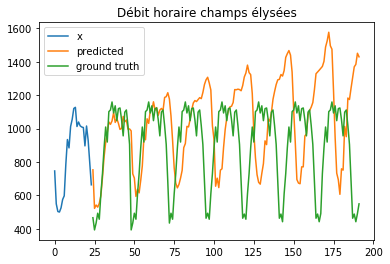

In [49]:
def display_comparison(X, true_y, pred_y, nb_steps):
    abscissa = range(24, 24 + nb_steps)
    plt.plot(range(24), X[0], label="x")
    plt.plot(abscissa, pred_y[:nb_steps], label="predicted")
    plt.plot(abscissa, ground_truth_y[:nb_steps], label="ground truth")
    plt.title("Débit horaire champs élysées")
    plt.legend()
display_comparison(X, ground_truth_y, pred_y, 168)
print(np.mean(abs(ground_truth_y[:168]-pred_y)))